<div align="right"><em>Машинне навчання. Лабораторний практикум</em></div>

# Лабораторна робота №8
## Реалізація алгоритмів онлайн-навчання. Бібліотека Vowpal Wabbit


---


## Завдання

Набір даних (archive.zip) містить тексти арабською мовою, а саме відгуки про фільми, книги, продукти і т.д., що поділяються на три класи: позитивні, негативні та змішані.

Будемо розв'язувати задачу бінарної класифікації з використанням бібліотеки [Vowpal Wabbit](https://github.com/VowpalWabbit/vowpal_wabbit).

**Необхідно:**
1. Завантажити дані;
2. Видалити з набору відгуки з міткою ('Mixed');
3. Розділити дані на навчальну і відкладену частини;
4. Конвертувати дані у формат VW; 
5. Навчити модель Vowpal Wabbit з логістичною функцією втрат на навчальних даних;
6. Оцінити якість роботи класифікатора на відкладених даних:
    - обчислити показник якості ROC AUC ($\ge 0.925$); 
    - відобразити ROC-криву.

## Виконання завдання

In [32]:
import vowpalwabbit as vw
import pandas as pd
import re
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import zipfile
import matplotlib.pyplot as plt

LOCAL_DATA_DIR = '../data'

1. #### Завантажити дані

In [33]:
with zipfile.ZipFile(LOCAL_DATA_DIR + "/archive.zip", mode="r") as zip_file:
    df = pd.read_csv(zip_file.open('ar_reviews_100k.tsv'), sep='\t')
    zip_file.close()

print('Data Frame preview: ', df, '\n')
print('\nData Frame details:\n', '-'*50, df.describe()) 
print('\n', '-'*50)
print(f"{df['label'].value_counts()}") 

Data Frame preview:            label                                               text
0      Positive  ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1      Positive  أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2      Positive  هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3      Positive  خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4      Positive  ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
...         ...                                                ...
99994  Negative  معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...
99995  Negative  لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...
99996  Negative  كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...
99997  Negative  مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...
99998  Negative  لن ارجع إليه مرة اخرى . قربه من البحر. المكان ...

[99999 rows x 2 columns] 


Data Frame details:
 --------------------------------------------------            label                                               text
count 

2. #### Видалити з набору відгуки з міткою ('Mixed')

In [34]:
df = df[df['label'] != 'Mixed']

df['label'].unique()

array(['Positive', 'Negative'], dtype=object)

3. #### Розділити дані на навчальну (training) і відкладену (holdout/testing) частини

In [69]:
# prepare label values for vw format {-1; 1}
text_train, text_test, label_train, label_test = train_test_split(df['text'], df['label'].replace('Positive', 1).replace('Negative', -1), shuffle=True, test_size=0.2)

4. #### Конвертувати дані у формат VW

In [70]:
to_vw_format = lambda text, label=None: f"{str(label or '')} |text " + ' '.join(re.findall("\w{3,}", text.lower())) + '\n' 

# for the train data
with open(LOCAL_DATA_DIR + '/data_train.vw', 'w', encoding='utf-8') as vw_train:
    for label, text in zip(label_train, text_train):
        vw_train.write(to_vw_format(text=text, label=label))
        
# for the test data
with open(LOCAL_DATA_DIR + '/data_test.vw', 'w', encoding='utf-8') as vw_test:
    for text in text_test:
        vw_test.write(to_vw_format(text=text))

5. #### Навчити модель Vowpal Wabbit з логістичною функцією втрат на навчальних даних

In [71]:
!vw -d $LOCAL_DATA_DIR/data_train.vw \
--loss_function=logistic -f $LOCAL_DATA_DIR/model.vw

final_regressor = ../data/model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../data/data_train.vw
num sources = 1
Enabled reductions: gd, scorer
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.0000       27
0.646487 0.599828            2            2.0  -1.0000  -0.1963       44
0.623911 0.601335            4            4.0  -1.0000  -0.1010        6
0.647937 0.671962            8            8.0  -1.0000  -0.3827       49
0.779325 0.910713           16           16.0   1.0000  -0.0003       18
0.707039 0.634752           32           32.0  -1.0000  -0.1499        5
0.687623 0.668207           64           64.0  -1.0000  -0.1538        6
0.695465 0.703308          128          128.0  -1.0000  -0.0826       45
0.669399 0.643333          256          256.0   1.0000   0.0453

6. #### Оцінити якість роботи класифікатора на відкладених даних

In [72]:
!vw -i $LOCAL_DATA_DIR/model.vw -t -d $LOCAL_DATA_DIR/data_test.vw \
-p $LOCAL_DATA_DIR/test_predictions.txt

only testing
predictions = ../data/test_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../data/data_test.vw
num sources = 1
Enabled reductions: gd, scorer
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown  -0.9366        6
    n.a.     n.a.            2            2.0  unknown   0.4718       11
    n.a.     n.a.            4            4.0  unknown   0.3405       51
    n.a.     n.a.            8            8.0  unknown  -5.3527        8
    n.a.     n.a.           16           16.0  unknown   2.8721       64
    n.a.     n.a.           32           32.0  unknown   2.8700       29
    n.a.     n.a.           64           64.0  unknown   6.2765      314
    n.a.     n.a.          128          128.0  unknown   2.9438       12
    n.a.     n.a.          256          256

#### обчислити показник якості ROC AUC ($\ge 0.925$)

In [73]:
with open(LOCAL_DATA_DIR+'/test_predictions.txt', mode='r') as pred_file:
    prediction_test = [float(label) for label in pred_file.readlines()]

auc, rcurve = roc_auc_score(label_test, prediction_test), roc_curve(label_test, prediction_test)

auc

0.9263516285795336

#### відобразити ROC-криву

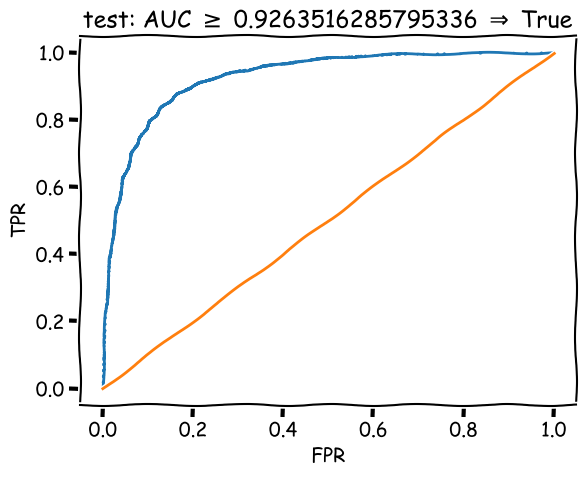

In [74]:
with plt.xkcd():
    plt.plot(rcurve[0], rcurve[1])
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR') 
    plt.title(f'test: AUC $\\geq$ {auc} $\\Rightarrow$ {auc >= 0.925}') 
    plt.axis([-0.05,1.05,-0.05,1.05])
    plt.show()